# Exercise 3: Clinical notes and natural language processing


In this exercice we introduce an important new category of data: **clinical notes**.
<br>We provide a scientific library called **eds-nlp** (see [doc](https://aphp.github.io/edsnlp)) that has been developed to facilitate the definition of rule-based NLP algorithms on French clinical texts.

Here, we want to validate the drug table. 
<br>In fact, we think that the drug table is not complete. Therefore, some patients might be identified in the control cohort but have had a drug administred. 
<br>It is well known that the medical staff writes all the needed information in the notes. We suppose that the note table is complete. 
<br>The idea is to use NLP to extract the drugs taken by patients. 

In this exercice, we will : 
1. Find drug administration for patients using NLP methods
2. Compare the Kaplan Meyer curves between populations depending if NLP was used to identify drugs.

We initialize the notebook by importing the following libraries:

In [2]:
import pandas as pd
import numpy as np

# Visualization library
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

# Dates management
import datetime

# For the computation of Kaplan-Meier estimates and log-rank tests
import lifelines

 # Table of content

# 1. Data Exploration

A fake dataset that mimics data coming from a clinical information system is made available in the */data* folder of this exercise.
<br>For this study, data has been extracted from the Clinical Data Warehouse on December 1st, 2025.
<br>The same data than in exercice 1 is imported

## 1.1 Data extracted from the Clinical Data Warehouse

Open the following files using the `pandas.read_pickle()` function : 
  - *data/df_person.pkl* as `df_person`
  - *data/df_visit.pkl* as `df_visit`
  - *data/df_condition.pkl* as `df_cond`
  - *data/df_med.pkl* as `df_med`

In [3]:
# Patients
df_person = pd.read_pickle('data/df_person.pkl')
# Visits
df_visit = pd.read_pickle('data/df_visit.pkl')
# Diagnosis (condition)
df_cond = pd.read_pickle('data/df_condition.pkl')
# Medication
df_med = pd.read_pickle('data/df_med.pkl')

Create a dataframe `df_visit_med` that indicates which drug was administered for each visit. 

TIP : LEFT JOIN `df_visit` and `df_med` on `visit_occurrence_id` using the `pandas.merge()` function (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.merge.html))

In [4]:
df_visit_med = #TODO

How many patients are in the study?
<br>We suppose deduplication has already been done.

In [5]:
print(f"We have {#TODO} unique patient ids in this dataset.")

We have 60000 unique patient ids in this dataset.


Make sure every patient only has one visit and therefore one drug administration

TIPS : Count the number of patients in the dataset `df_visit_med` using `pandas.value_counts()` and check there is only one occurence of every patient.

In [6]:
#TODO

We see that every patient only has one visit and therefore one drug administration


How many patients have had the drug : 
- drugA  administered ?
- drugB administered ?

TIP : Count the number of drugA and drugB administered in the dataset `df_visit_med` using `pandas.value_counts()` 

In [7]:
count_drug = #TODO
print(f" {#TODO} patients have had the drugA administered. \n{#TODO} patients have had the drugB administered.")

 13850 patients have had the drugA administered. 
9039 patients have had the drugB administered.


How many patients have had no drug administered according to the structured information?

In [8]:
print(f"{#TODO} patients have had no drugs administerd.")

32300 patients have had no drugs administerd.


## 1.2 Clinical Notes

In this exercise we introduce two new categories of data:
- **free text** contained in clinical notes (*i.e.* raw data)
- variables that have been **extracted by a pre-defined NLP algorithm** (*i.e.* extracted data).

Free text is made available in a *df_note* dataframe

- Open the *data/df_note.pkl* file as `df_note` using the pandas.read_pickle() function.
- Explore the type of each feature of the df_note DataFrame with the .info() function.
- Check out the first rows of the DataFrame using the .head() function.

In [9]:
#TODO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78000 entries, 0 to 77999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   visit_occurrence_id  78000 non-null  int64         
 1   note_datetime        78000 non-null  datetime64[ns]
 2   note_id              78000 non-null  int64         
 3   cdm_source           78000 non-null  object        
 4   note_text            78000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 3.0+ MB


,visit_occurrence_id,note_datetime,note_id,cdm_source,note_text
0,80267746,2021-08-30,89456596,EHR 1,Le patient a des nausées et de vomissement dep...
1,82726004,2022-05-14,87921085,EHR 1,Le patient est connu des services de soins de ...
2,80889208,2024-02-26,83544580,EHR 1,Le patient a été hospitlisé l'année dernière d...
3,81267189,2020-05-13,87288459,EHR 1,Le patient est arrivé ce matin.\ndrugB et Spin...
4,89982511,2020-03-14,87593924,EHR 1,Le patient a des nausées et de vomissement dep...


`df_note` is composed of 5 columns :
- *visit_occurrence_id* : identifier of the visit
- *note_id* : identifier of the medical note
- *note_text* : free text contained in the medical note
- *note_datetime* : date of text edition
- *cdm_source* : name of the clinical software

Print an example of a note using the funciton `pandas.sample()`

TIP : Use the function `pandas.sample()`(see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)) and the function `pandas.squeeze()`(see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.squeeze.html))

In [10]:
print(#TODO)

Le patient est arrivé via les urgences.
La patient n'a pas été exposé aux traitements SpinA
Le patient est arrivée au urgence pour diarrhée depuis ce matin.


# 2. First steps with natural language processing


Let's now define a new rule-based NLP algorithm that extracts drugs mentioned in clinical notes. 

We define a rule-based algorithm that consists in looking for mentions of drugs in the texts and in discarding false positive detections by predicting modifiers (negation, etc.).

**Step 1: Definition of the vocabularies**

We start by asking clinicians to consolidate a list of synonyms used to report the usage of drug A or drug B in the clinical notes:

In [11]:
# Les médecins nous ont fourni les synonymes suivants.

terms = dict(
    drugA=['drugA', 'pneumo-drug', 'SpinA'],
    drugB=['drugB', 'noso-plat', 'testmedB'],
    medicament=['médicament', 'médicamenteux']
)

**Step 2: Definition of a natural language processing pipeline (rule-based)**

The documentation for the NLP librairie is available [here](https://aphp.github.io/edsnlp)

We now integrate this dictionary in a NLP-pipeline as described in the *eds-nlp* documentation, in order to realize the various pre-processing steps necessary to extract a meaningful variable:

In [12]:
#Utiliser edsnlp pour extraitre les 3 entités ci dessus : 
import spacy
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load declared pipelines
# from edsnlp import components
from edsnlp.processing.parallel import pipe as parallel_pipe
from spacy import displacy

Create a first pipeline using :
- eds.sentences 
- eds.normalier
- eds.matcher with `terms` as the configuration file
- eds.negation

In [13]:
#TODO

Apply the pipeline to one document to see if it works (see [doc](https://aphp.github.io/edsnlp/latest/tutorials/matching-a-terminology/#visualising-matched-entities)).

TIPS : 
- Use the function `pandas.sample()`(see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)) and the function `pandas.squeeze()`(see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.squeeze.html)) to extract a text.
- Apply your nlp pipeline to create a `doc`
- Apply `displacy.render()`

In [14]:
#TODO

**Step 3: Application of the natural language processing pipeline on all the clinical notes**

Apply this NLP pipeline to the texts of our dataset to extract entities by using the `edsnlp.parallel_pipe()` function (see [doc](https://aphp.github.io/edsnlp/latest/tutorials/multiple-texts/#processing-a-pandas-dataframe)).
<br>You should obtain a `pd.DataFrame` *ents*

A `pick_result` function is given to standardise the output (results_extrator)


In [15]:
def pick_results(doc):
    """
    This function provides the entities that must be collected by the nlp process.
    """
    return [{
             'note_id':e.doc._.note_id,
             'visit_occurrence_id':e.doc._.visit_occurrence_id,
             'lexical_variant':e.text,
             'label':e.label_,
             'negation':e._.negation
             } 
             for e in doc.ents if doc.ents]

In [16]:
#TODO

Show the first rows of the dataframe `ents`

In [17]:
#TODO

,note_id,visit_occurrence_id,lexical_variant,label,negation
0,89456596,80267746,SpinA,drugA,False
1,87921085,82726004,noso-plat,drugB,False
2,83544580,80889208,testmedB,drugB,True
3,87288459,81267189,drugB,drugB,False
4,87288459,81267189,SpinA,drugA,True


**Step 4: Create rules to classify each result and identify the patients for each drug**

First, we classify each entity detected according to the rules bellow : 

- (drugA OR drugB OR medicament) AND NEGATION = control
- drugA AND NOT(NEGATION) = cohortA
- drugB AND NOT(NEGATION) = cohortB
- else : unknown
  
Then, for a given `note_id` aka a given `visit_occurrence_id`, we combine the entities detected and classified as followed : 
- if control + cohortA = ambiguous
- if control + cohortB = ambiguous
- if cohortA + cohortB = ambiguous
- if control + unknown = control
- if cohortA + unknown = cohortA
- if cohortB + unknown = cohortB

The classification function `calc_value` is provided. <br>

In [ ]:
def calc_value(x):
    state = "unknown"
    for _, row in x.iterrows():
        if row['label'] in ['medicament', 'drugA', 'drugB'] and row['negation']:
            if state == "unknown" or state == "control":
                state = "control"
            else:
                state = "ambiguous"
        elif row['label'] == 'drugA' and not row['negation']:
            if state == "unknown" or state == "drugA":
                state = "drugA"
            else:
                state = "ambiguous"
        elif row['label'] == 'drugB' and not row['negation']:
            if state == "unknown" or state == "drugB":
                state = "drugB"
            else:
                state = "ambiguous"
    return state

Create a `pd.DataFrame` *ents_grouped* with the processed data extracted from clinical notes.

`ents_grouped` is composed of 2 columns :
- *visit_occurrence_id* : identifier of the visit
- *drug_source_value* : The output of the NLP° and the classification algorithm

In [ ]:
undesired_state = ['unknown', 'ambiguous']
ents_grouped = #TODO

**Step 5: Compare nlp results to structured data provided by the hospitals**


Acccording to the NLP-pipeline, how many patients have had the drug : 
- drugA  administered ?
- drugB administered ?

TIP : Count the number of drugA and drugB administered in the dataset `ents_grouped` using `pandas.value_counts()` 

In [19]:
#TODO

drugA        19501
drugB        19387
control      15877
ambiguous     5235
Name: drug_source_value, dtype: int64

# 3. Statistical analysis

Now that we have identified drug admission using NLP,  we can conduct the statistical analysis showing the impact of the missing data . 
<br>We plot the Kaplan-Meier estimates of survival curves, and realize the log-rank tests.
<br> The same functions `plot_primary_kaplan` used in the previous notebook can be used to plot the curves.
<br> If needed, you can print the docstrings using `print(plot_primary_kaplan.__doc__)`.

In this exercice, we have only kept the visits regarding the epidemic conditions. `df_visit` and `df_med` can be used to without any preprocessing.

In [20]:
t_end_of_study = datetime.date(2025,12,1)

In [21]:
 #Import the helper functions
import sys
sys.path.append("../")
from viz import plot_primary_kaplan, plot_secondary_kaplan

## 3.1 Without NLP extraction algorithm the person dataset

Plot the  primary Kaplan-Meier estimates for the whole `df_person` DataFrame

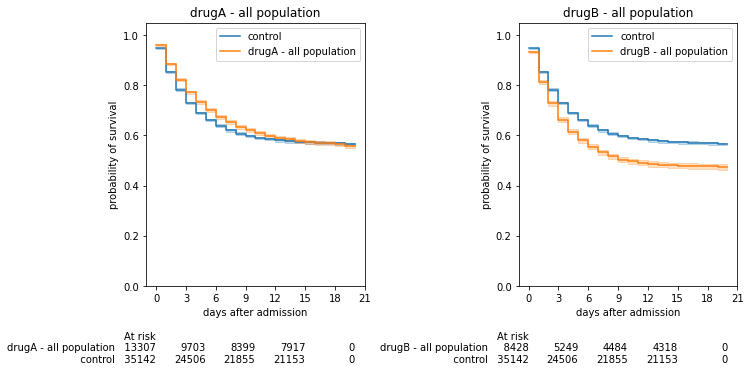

In [22]:
#TODO

What can be concluded on the effect of each drugs?

**Correction** :
<br> It seems that drugA has a positive impact on the survival of the patients.
<br> but that drugB doesn't.

## 3.2 Using the NLP extraction algorithm

Plot the  primary Kaplan-Meier estimates for the whole `ents_grouped` dataFrame

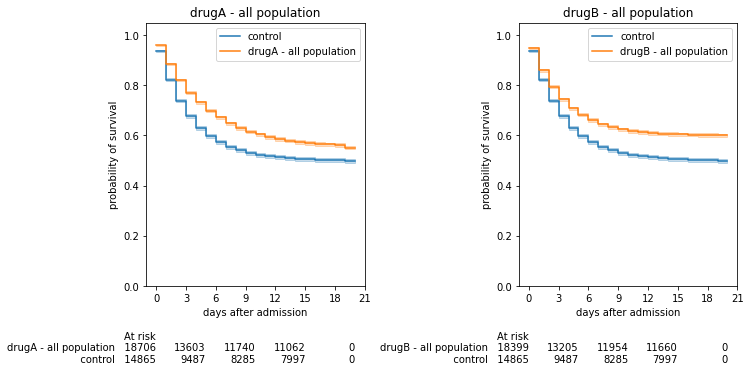

In [23]:
#TODO

In this exercise we have illustrated some challenges related to handling clinical notes when conducting a study using real-world data. We have shown that different approaches may be adopted and compared.

# V. Takeaways


- **Clinical notes** are unstructured data that contain numerous pieces of information but which is challenging to analyze. Specific pre-processing pipelines should be developed, validated and deployed to extract structured variables out of unstructured texts (**Natural Language Processing** algorithms - NLP).
- Natural Language processing algorithms rely either on a **rule-based approach** or on a **machine learning approach**. Whereas rule-based approaches are technically simpler than machine learning approaches, they require a strong contribution of expert clinicians to handcraft rules. Both approaches have their pros and cons and they may be compared on some specific tasks.
- A single variable used at the statistical analysis stage may be **defined leveraging various sources of data**, either structured or unstructured. The methodology used to define each variable may impact the result of the statistical analysis, and it should consequently be discussed.

# VI. References

- Honnibal, Matthew, Ines Montani, Matthew Honnibal, Henning Peters, Sofie Van Landeghem, Maxim Samsonov, Jim Geovedi, et al. explosion/spaCy: v2.1.7: Improved evaluation, better language factories and bug fixes. Zenodo, 2019. https://doi.org/10.5281/zenodo.3358113.
- Aronow, D. B., F. Fangfang, et W. B. Croft. « Ad Hoc Classification of Radiology Reports ». Journal of the American Medical Informatics Association 6, nᵒ 5 (1 septembre 1999): 393‑411. https://doi.org/10.1136/jamia.1999.0060393.
- Garcelon, Nicolas, Antoine Neuraz, Vincent Benoit, Rémi Salomon, et Anita Burgun. « Improving a Full-Text Search Engine: The Importance of Negation Detection and Family History Context to Identify Cases in a Biomedical Data Warehouse ». Journal of the American Medical Informatics Association, 20 octobre 2016, ocw144. https://doi.org/10.1093/jamia/ocw144.
- Jouffroy, Jordan, Sarah F Feldman, Ivan Lerner, Bastien Rance, Anita Burgun, et Antoine Neuraz. « Hybrid Deep Learning for Medication-Related Information Extraction From Clinical Texts in French: MedExt Algorithm Development Study ». JMIR Medical Informatics 9, nᵒ 3 (16 mars 2021): e17934. https://doi.org/10.2196/17934.
- Névéol, Aurélie, Hercules Dalianis, Sumithra Velupillai, Guergana Savova, et Pierre Zweigenbaum. « Clinical Natural Language Processing in Languages Other than English: Opportunities and Challenges ». Journal of Biomedical Semantics 9, nᵒ 1 (décembre 2018): 12. https://doi.org/10.1186/s13326-018-0179-8.